In [2]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
import dask.array as da



la simulation chargée est: dahu_519
depuis: dahu
KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 132)> Size: 528B
array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75,
       1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35,
       2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95,
       3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55,
       3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15,
       4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75,
       4.8 , 4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
       5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95,
       6.  , 6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55],
   

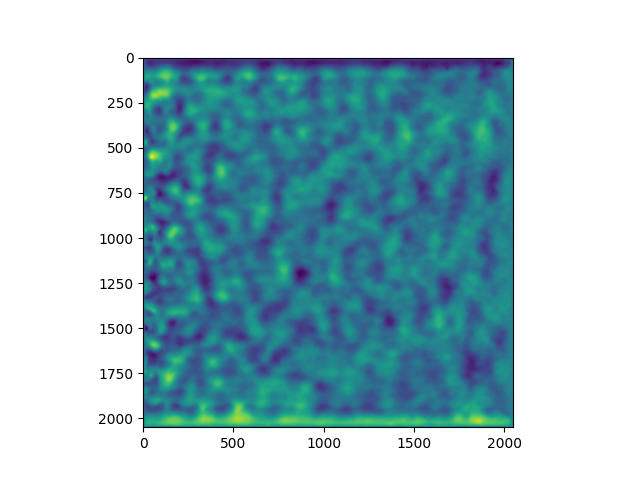

In [3]:


# Number of simulation
n = 519

# Choose between 'local' or 'dahu'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'
else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})

print(dataset.variables.keys())

# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data

# Lecture des paramètres :
param = io.read_params(Path)
print(param)
f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
nx = int(param['NX'])
ny = int(param['NY'])
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

plt.figure()
plt.imshow(psi[-2, :, :])
print(np.shape(t))


In [4]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [8]:
#Computing k_rhines to have an idea of the modes to choose

epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)

print('k_rhines =',k_rhines)    

n=Lx*k_rhines/(2*np.pi)
print("Just look arround n",n)

k_rhines = 0.25
Just look arround n 19.999999999826247


(132,)


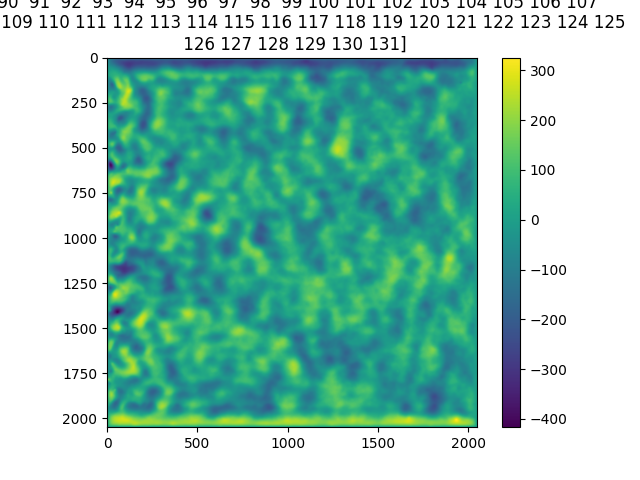

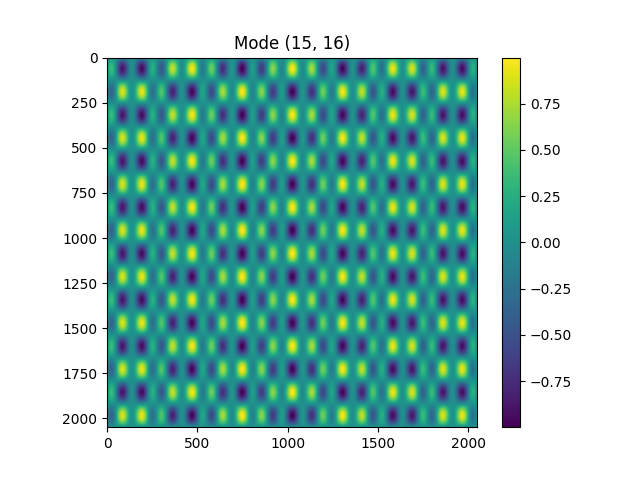

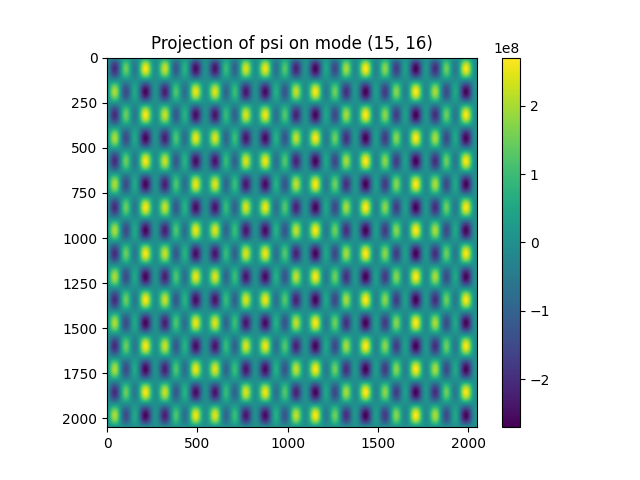

In [9]:
m_sel=15
n_sel=16

time_sel=np.arange(0,len(t),1,dtype=int)


psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 1)
print(np.shape(psi_mn))
# Visualize the original field
plt.figure()
plt.imshow(psi[0, :, :])
plt.colorbar()
plt.title(f'Original field at time {time_sel}')
plt.show()

# Construct and visualize the mode
N = np.shape(psi[1, :, :])[-1]
x = np.linspace(0, Lx, N)
y = np.linspace(0, Lx, N)
X, Y = np.meshgrid(x, y)

mode = np.exp(-1j*np.pi*np.sqrt(m_sel**2 + n_sel**2)*X/Lx) * np.sin(m_sel*np.pi*X/Lx) * np.sin(n_sel*np.pi*Y/Lx)

plt.figure()
plt.imshow(np.real(mode))
plt.colorbar()
plt.title(f'Mode ({m_sel}, {n_sel})')
plt.show()

# Reconstruct and visualize the projected field
reconstructed_field = np.real(psi_mn[1] * mode)

plt.figure()
plt.imshow(reconstructed_field)
plt.colorbar()
plt.title(f'Projection of psi on mode ({m_sel}, {n_sel})')
plt.show()


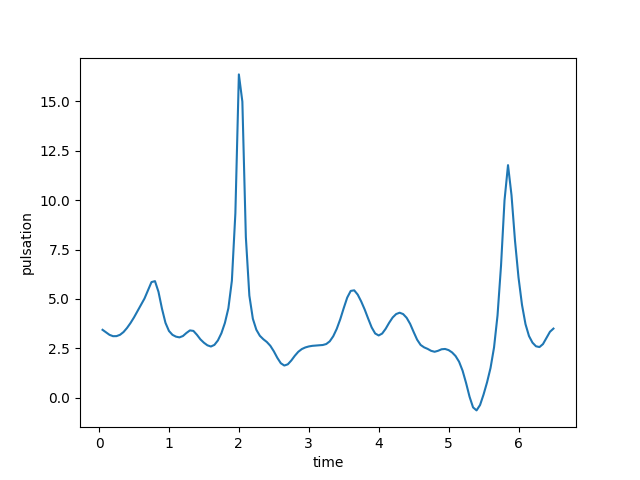

In [11]:
dt=t[1]-t[0]    

# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

plt.figure()
plt.plot(t[1:-1],pulsation_observed)
plt.xlabel('time')
plt.ylabel('pulsation')
plt.show()

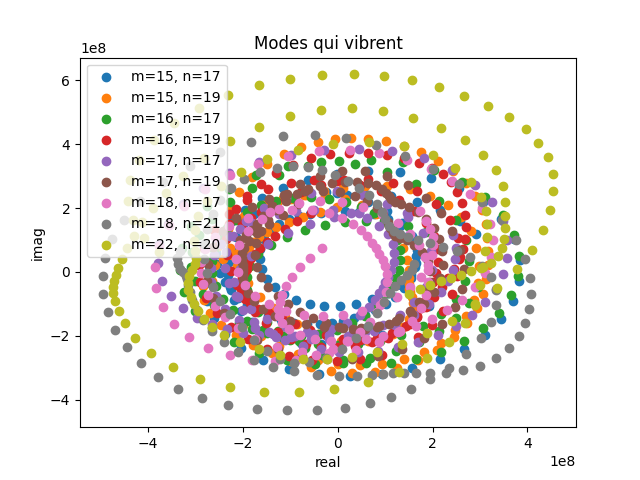

In [ ]:
#Code with parallelization

from joblib import Parallel, delayed




# Parameters
m_list = np.arange(15, 24, 1)
n_list = np.arange(15, 22, 1)
epsilon1 = 0.4
epsilon2 = 0.4
time_sel=np.arange(0,len(t),1,dtype=int)

pi = np.pi

def process_mode(m_sel, n_sel):
    """
    Process a single (m, n) mode and return the data for plotting if conditions are met.
    """
    #pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * pi)
    
    #finding the projection of the field on the mode
    psi_mn = project_basin(psi[time_sel, :, :], m_sel, n_sel, Lx, norm=1)
    
    dt = t[1] - t[0]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    
    print(m_sel, n_sel)
    if condition1 and condition2:

        return (real, imag, m_sel, n_sel)
    return None

results = Parallel(n_jobs=-1)(delayed(process_mode)(m, n) for m in m_list for n in n_list)

# Plotting
plt.figure()
for result in results:
    if result is not None:
        real, imag, m_sel, n_sel = result
        print(m_sel, n_sel)
        plt.scatter(real, imag, label=f'm={m_sel}, n={n_sel}')
        plt.legend()

plt.xlabel('real')
plt.ylabel('imag')
plt.title('Modes qui vibrent')
plt.savefig("../figures/Wave_sign_closed_case/mode_vibration_{}_{}.png".format(epsilon1, epsilon2))
plt.show()


In [ ]:
# @hidden_cell
# #On va parcourir les m,n et regarder les modes qui correspondent à une vibration
# m_list = np.arange(15,24, 1)
# n_list = np.arange(15, 22, 1)
# epsilon1=0.4
# epsilon2=0.4

# print(len(m_list),len(n_list))
# pi=np.pi
# plt.figure()
# for i in range(len(m_list)):
#     for j in range(len(n_list)):
#         print(j)
#         #Computing the theoretical pulsation
        
#         pulsation_mode_theo=beta*Lx/(np.sqrt(m_list[i]**2+n_list[j]**2)*2*pi)
        
#         time_sel=np.arange(0,len(t),1,dtype=int)
#         m_sel=m_list[i]
#         n_sel=n_list[j]

#         psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 1)
#         dt=t[1]-t[0]    

#         # now we calculate the wave pulsation, using the same formula as for the spectral code
#         dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)
        
#         pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2
#         pulsation_var = pulsation_observed_brut**2
#         std=np.sqrt(np.mean(pulsation_var,axis=0)-np.mean(pulsation_observed_brut,axis=0)**2)
        
#         real=np.real(psi_mn)
#         imag=np.imag(psi_mn)
#         condition1 = np.std(np.abs(np.sqrt(real**2 + imag*2)) , axis=0)\
#                             /np.mean(np.abs(np.sqrt(real**2 + imag**2) ), axis=0)<epsilon1
#         condition2 = std/np.abs(np.mean(pulsation_observed_brut,axis=0)) < epsilon2
        
#         # if np.abs(pulsation_observed-pulsation_mode_theo)/np.abs(pulsation_mode_theo) < 0.1:
#         #     print("here")
#         #     real=np.real(psi_mn)
#         #     imag=np.imag(psi_mn)
#         #     plt.scatter(real,imag,label='m='+str(m_sel)+', n='+str(n_sel))
#         if condition1 and condition2:
#             print("here")
#             plt.scatter(real,imag,label='m='+str(m_sel)+', n='+str(n_sel))
#             plt.legend()
            
#             plt.xlabel('real')
#             plt.ylabel('imag')
#             plt.title('modes qui vibrent')
            

#     print("i",i)

# plt.savefig("../figures/Wave_sign_closed_case/mode_vibration_"+epsilon1+"_"+epsilon2+".png")
# plt.show()


        